# test_cylinder.ipynb

### Install

In [ ]:
pip install git+https://github.com/grmacchio/dynml.git

### Imports and Data Type Settings

In [2]:
from matplotlib.pyplot import subplots, show

from scipy.signal import find_peaks
from torch import float64, linspace, mean, set_default_dtype

from dynml.examples.cylinder import Cylinder
from dynml.dyn.discrete.numsolve import gen_num_trajs

In [3]:
set_default_dtype(float64)

### Generate a Trajectory

In [ ]:
ds = Cylinder()
t_chunk = 50.0
num_chunks = 12
num_samples = int(t_chunk / ds.dt) + 1
traj = gen_num_trajs(ds, ds.gen_ic, 1, num_samples)
for _ in range(num_chunks - 1):
    traj = gen_num_trajs(ds, lambda: traj[0, -1], 1, num_samples)

100%|██████████| 3767/3767 [13:56<00:00,  4.50it/s]


### Examine The Last State

In [ ]:
psi = traj[..., 0]
omega = traj[..., 1]

omega_last = omega[0, -1, :, :]
psi_last = psi[0, -1, :, :]
u1_last, u2_last = ds._vel(psi[0, -1, :, :])

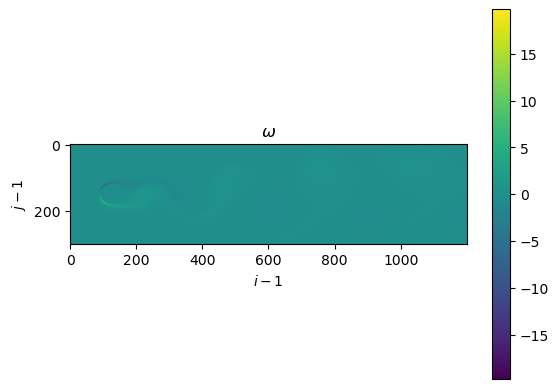

In [12]:
fig, ax = subplots()
plot = ax.imshow(omega_last)
fig.colorbar(plot)
ax.set_title("$\\omega$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

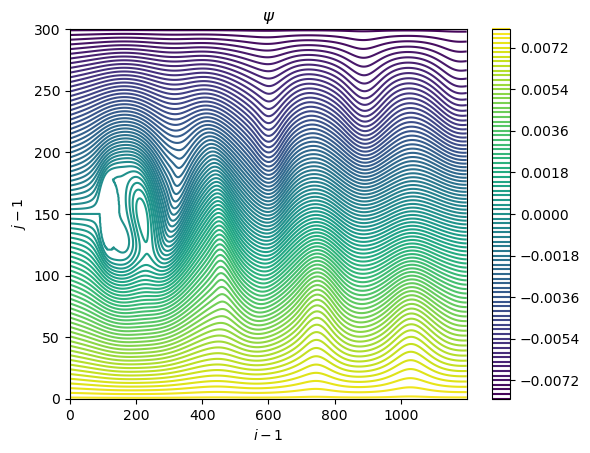

In [13]:
fig, ax = subplots()
plot = ax.contour(psi_last, levels=100)
fig.colorbar(plot)
ax.set_title("$\\psi$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

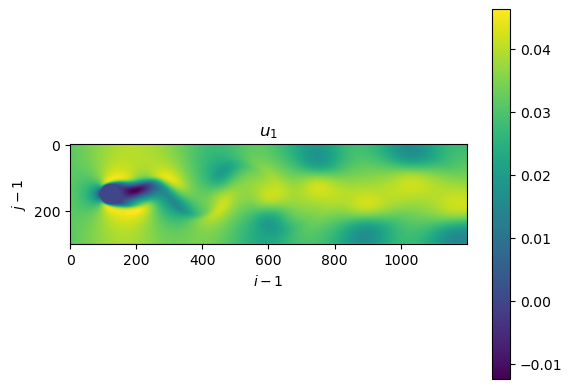

In [14]:
fig, ax = subplots()
plot = ax.imshow(u1_last)
fig.colorbar(plot)
ax.set_title("$u_1$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

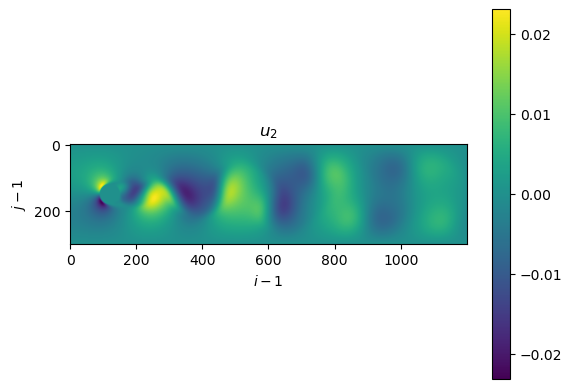

In [15]:
fig, ax = subplots()
plot = ax.imshow(u2_last)
fig.colorbar(plot)
ax.set_title("$u_2$")
ax.set_xlabel("$i - 1$")
ax.set_ylabel("$j - 1$")
show()

### Examine the Strouhal Number

Strouhal number: 0.204


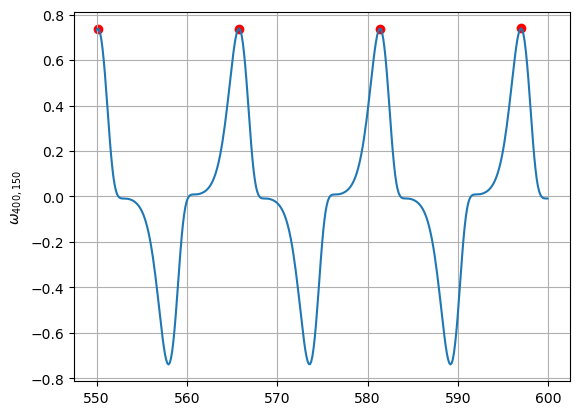

In [21]:
fig, ax = subplots()
t1 = (num_chunks - 1) * t_chunk
t2 = num_chunks * t_chunk
t_span = linspace(t1, t2, num_samples)[::10]
w = omega[0, ::10, ds.N_2, 400]
peaks, _ = find_peaks(w, height=0.1)
T = mean(t_span[peaks[1:]] - t_span[peaks[:-1]])
f = 1 / T
Sr = f * (2 * ds.R) / ds.U_inf
print(f"Strouhal number: {Sr:.3f}")
ax.plot(t_span, w)
ax.grid()
ax.scatter(t_span[peaks], w[peaks], marker='o', color='red')
ax.set_ylabel('$\\omega_{400, 150}$')
show()